# Governing equation (Laminar Blasius solution)
$$2\frac{\partial^3 F}{\partial \eta^3}+\frac{\partial^2 F}{\partial \eta^2}F=0$$
where $$F' = \frac{U}{U_{e}} $$ and $$\eta=y\sqrt{\frac{U_{e}}{\nu x}}$$
<br>
<br>
Boundary condition<br>
(At wall)
$$F(0)=F'(0)=0$$
(At freestream)<br>
$$F'(10)\sim = 1$$
<br>
# Domain
$$0<\eta<1$$
$$0<F'(\eta)<10$$


# Physics informed neural network on Blasius solution
We can use a neural network to approximate $F(\eta)$.
<br>
Denoting  $N(\eta)$ as a non-linear operator with $\eta$ as the input, which outputs our estimation of $F(\eta)$
<br>
<br>
With the governing equation and boundary conditions known, we hope the neural network respects the known physics. Thus, we construct a custom loss function, forcing the neural network into a physics informed neural network
<br>
<br>
# PINN Loss function
We can split the loss function into three components, namely governing equation, boundary condition and internal sampling
<br>
<br>
$$MSE_{total} = MSE_{Blasius} + MSE_{BC} + MSE_{sample}$$
where
$$MSE_{Blasius}=\frac{1}{N_{Blasius}}\sum^{N_{Blasius}}_{i=1}|2\frac{\partial^3 F}{\partial \eta^3}+\frac{\partial^2 F}{\partial \eta^2}F-0|^2$$
$$MSE_{sample}=\frac{1}{N_{sample}}\sum^{N_{sample}}_{i=1}|y(\eta)-NN(\eta)|^2$$
<br>
With modern deep learning infrastructure, the gradient of a function can be computed easily through autograd.grad in pytorch

In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np
import time
from pyDOE import lhs
import scipy.io

# Torch default type
torch.set_default_dtype(torch.float)

# Random seed
torch.manual_seed(1234)
np.random.seed(1234)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
if device=="cuda":
    print(torch.cuda.get_device_name())

cpu


# Discrete Blasius solution raw data
Generated from matlab solver (Runge_Kutta)<br>
Link can be found here:
https://uk.mathworks.com/matlabcentral/fileexchange/58996-blaisus-equation-solution

In [2]:
data = scipy.io.loadmat("Data/Blasius.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'eta', 'y1', 'y2', 'y3'])

torch.Size([1001, 1]) torch.Size([1001, 1])


Text(0.5, 0, '$F(\\eta)$')

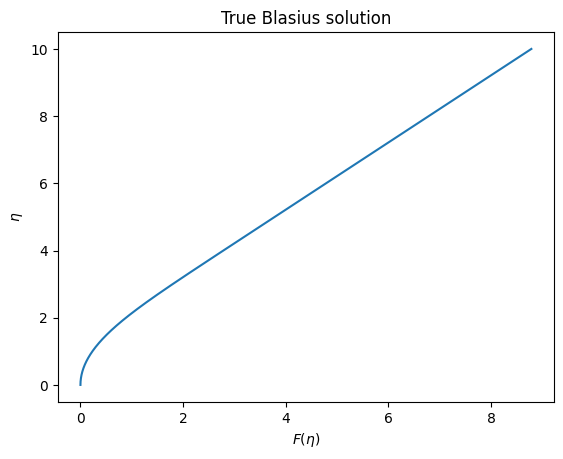

In [3]:
eta = torch.from_numpy(data["eta"]).view(-1,1)
f = torch.from_numpy(data["y1"]).view(-1,1)
print(f.shape,eta.shape)
plt.plot(f,eta)
plt.title("True Blasius solution")
plt.ylabel(r"$\eta$")
plt.xlabel(r"$F(\eta)$")

# Parameters

In [4]:
layers = np.array([1,50,50,50,50,50,50,1])# neural network layers
lr = 5e-4
Ns = 500 # Number of internal sample points
Nf = 5000 # Number of collocation points for governing equation
steps=10000

# Testing set

In [5]:
x_test = eta
y_test = f
lb = x_test[0]
ub = x_test[-1]
print("x_test shape:",x_test.shape,"test shape:",y_test.shape)
print("Lower bound : ",lb.numpy(),"Upper bound : ",ub.numpy())

x_test shape: torch.Size([1001, 1]) test shape: torch.Size([1001, 1])
Lower bound :  [0.] Upper bound :  [10.]


# Training set

In [6]:
# Boundary condition
# x = 0
min_x = lb[:,None]
min_y = torch.zeros(min_x.shape[0],1)

# x = 10
max_x = ub[:,None]
max_y = y_test[-1][:,None]

x_train_wall = min_x
y_train_wall = min_y

x_train_freestream = max_x

print("Min x shape : ",min_x.shape,"Min y shape : ",min_y.shape)
print("Max x shape : ",max_x.shape,"Max y shape : ",max_y.shape)
print("x train wall shape : ",x_train_wall.shape,"y train wall shape : ",y_train_wall.shape)
print("x train freestream shape : ",x_train_freestream.shape)#,"y train freestream shape : ",y_train_freestream.shape)

# Latin hypercube sampling for collocation points
x_train_nf = (lb + (ub - lb)*lhs(1,Nf))
x_train_nf = torch.vstack([x_train_nf,x_train_wall,x_train_freestream])
print("x train nf shape : ",x_train_nf.shape)

# Internal sample point
idx = np.random.choice(eta.shape[0],size=Ns,replace=False)
x_train_sample = eta[idx]
y_train_sample = f[idx]
print("x train sample shape : ",x_train_sample.shape,"y train sample shape : ",y_train_sample.shape)


Min x shape :  torch.Size([1, 1]) Min y shape :  torch.Size([1, 1])
Max x shape :  torch.Size([1, 1]) Max y shape :  torch.Size([1, 1])
x train wall shape :  torch.Size([1, 1]) y train wall shape :  torch.Size([1, 1])
x train freestream shape :  torch.Size([1, 1])
x train nf shape :  torch.Size([5002, 1])
x train sample shape :  torch.Size([500, 1]) y train sample shape :  torch.Size([500, 1])


In [7]:
# Boundary condition
X_train_wall = (x_train_wall).float().to(device)
Y_train_wall = (y_train_wall).float().to(device)
X_train_freestream = (x_train_freestream).float().to(device)

# Internal sampling
X_train_sample = (x_train_sample).float().to(device)
Y_train_sample = (y_train_sample).float().to(device)

# Governing equation
X_train_nf = (x_train_nf).float().to(device)
f_hat = torch.zeros(X_train_nf.shape[0],1).float().to(device)

# Testing
X_test = (x_test).float().to(device)
Y_test = (y_test).float().to(device)

print("f_hat shape : ",f_hat.shape)

f_hat shape :  torch.Size([5002, 1])


In [8]:
class PINN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss()
        self.linears = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        # Parameters initialisation
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    
    def forward(self,x):
        if not(torch.is_tensor(x)):
            a = torch.from_numpy(x)

        u_b = (ub).float().to(device)
        l_b = (lb).float().to(device)
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        a = x.float()
        for i in range(len(layers)-2):
            z = self.activation(a)
            a = self.linears[i](z)
        a = self.linears[-1](a)
        
        return a

    def loss_BC_wall(self,x_BC):
        g = x_BC.clone()
        g.requires_grad = True
        f = self.forward(g)
        f_x = autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        f_xx = autograd.grad(f_x,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        f_eta = f_x[:,[0]]
        f_eta_eta = f_xx[:,[0]]     
        
        zero= torch.zeros(x_BC.shape[0],1)
        loss_f = self.loss_function(f,zero) # f is equal to zero at wall
        loss_f_eta = self.loss_function(f_eta,zero) # As f' is also equal to zero

        return loss_f + loss_f_eta
    
    def loss_BC_freestream(self,x_BC):
        g = x_BC.clone()
        g.requires_grad = True
        f = self.forward(g)
        f_x = autograd.grad(f,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        f_eta = f_x[:,[0]]
        
        one = torch.ones(x_BC.shape[0],1)
        loss_f_eta_freestream = self.loss_function(f_eta,one)
        
        return loss_f_eta_freestream
    
    def loss_PDE(self,x_PDE):
        g = x_PDE.clone()
        g.requires_grad = True
        f = self.forward(g)
        f_x = autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        f_xx = autograd.grad(f_x,g,torch.ones(g.shape).to(device),retain_graph=True,create_graph=True)[0]
        f_xxx = autograd.grad(f_xx,g,torch.ones(g.shape).to(device),create_graph=True)[0]
        f_eta = f_x[:,[0]]
        f_eta_eta = f_xx[:,[0]]        
        f_eta_eta_eta = f_xxx[:,[0]]
        
        f = 2*f_eta_eta_eta + f_eta_eta*f
        
        loss_f = self.loss_function(f,f_hat)
        
        return loss_f
    
    def loss_sample(self,x_sample,y_sample):
        return self.loss_function(self.forward(x_sample),y_sample)
    
    def loss(self,x_wall,x_freestream,x_PDE,x_sample,y_sample):
        return (self.loss_BC_wall(x_wall) + self.loss_PDE(x_PDE)
                + self.loss_BC_freestream(x_freestream) + self.loss_sample(x_sample,y_sample))
    
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()       
        loss = self.loss(X_train_wall, X_train_freestream, X_train_nf, X_train_sample, Y_train_sample)
        loss.backward()
        self.iter += 1
        
        if self.iter % 50 == 0:
            test_loss = self.loss_function(self(X_test),Y_test)
            print("Iteration: ",self.iter,loss,test_loss)

        return loss  

In [9]:
Model = PINN(layers)
Model.to(device)
print(Model) # Model summary

# 'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(Model.parameters(), lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-201, 
                              tolerance_change = 1e-201, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')


start_time = time.time()

optimizer.step(Model.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)
Iteration:  50 tensor(2.8199, grad_fn=<AddBackward0>) tensor(1.0469, grad_fn=<MseLossBackward0>)
Iteration:  100 tensor(1.2058, grad_fn=<AddBackward0>) tensor(0.3261, grad_fn=<MseLossBackward0>)
Iteration:  150 tensor(0.3103, grad_fn=<AddBackward0>) tensor(0.0401, grad_fn=<MseLossBackward0>)
Iteration:  200 tensor(0.2411, grad_fn=<AddBackward0>) tensor(0.0258, grad_fn=<MseLossBackward0>)
Iteration:  250 tensor(0.1498, grad_fn=<AddBackward0>) tensor(0.0269, grad_fn=<MseLossBackward0>)
Iter

In [10]:
g = X_test.clone()
g.requires_grad = True
y1 = Model(g)
y2 = autograd.grad(y1,g,torch.ones([X_test.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]

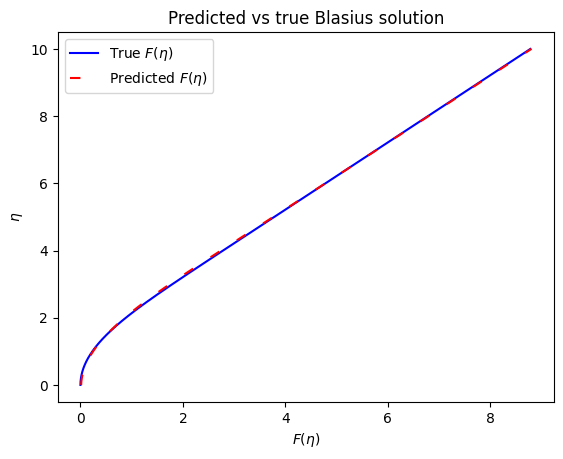

In [11]:
plt.plot(y_test.detach().numpy(),x_test.detach().numpy(),'b') # Real solution
plt.plot(y1.detach().numpy(),eta,linestyle='--',dashes=(5, 10),color="r") # predicted solution
plt.title("Predicted vs true Blasius solution")
plt.ylabel(r"$\eta$")
plt.xlabel(r"$F(\eta)$")
plt.legend([r"True $F(\eta)$",r"Predicted $F(\eta)$"])

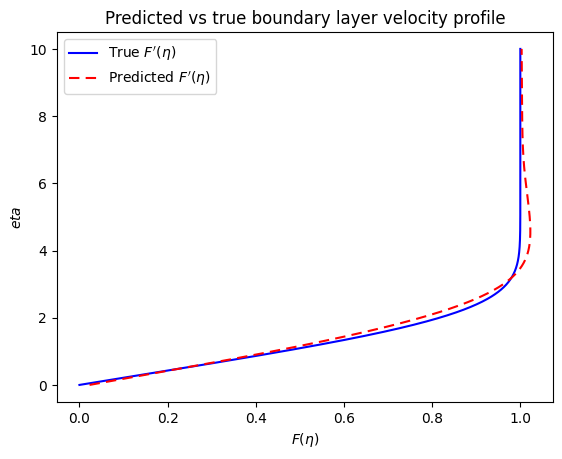

In [12]:
f_eta = torch.from_numpy(data["y2"]).view(-1,1)
plt.plot(f_eta,eta,"b")
plt.plot(y2.detach().numpy(),eta,linestyle='--',dashes=(5, 3),color="r")
plt.title("Predicted vs true boundary layer velocity profile")
plt.ylabel(r"$eta$")
plt.xlabel(r"$F(\eta)$")
plt.legend([r"True $F'(\eta)$",r"Predicted $F'(\eta)$"])